In [4]:
import pandas as pd
import numpy as np

import matplotlib 
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB

from scipy.stats import relfreq

import networkx as nx

In [5]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')

In [ ]:
df['uniq_ratio'] = 1 / df['uniq_ratio']

In [6]:
df.drop(columns=['artist_base', 'song'], inplace=True)
df.rename(columns={'artist_clean': 'artist_base', 'song_clean': 'song'}, inplace=True)

## Features distribution

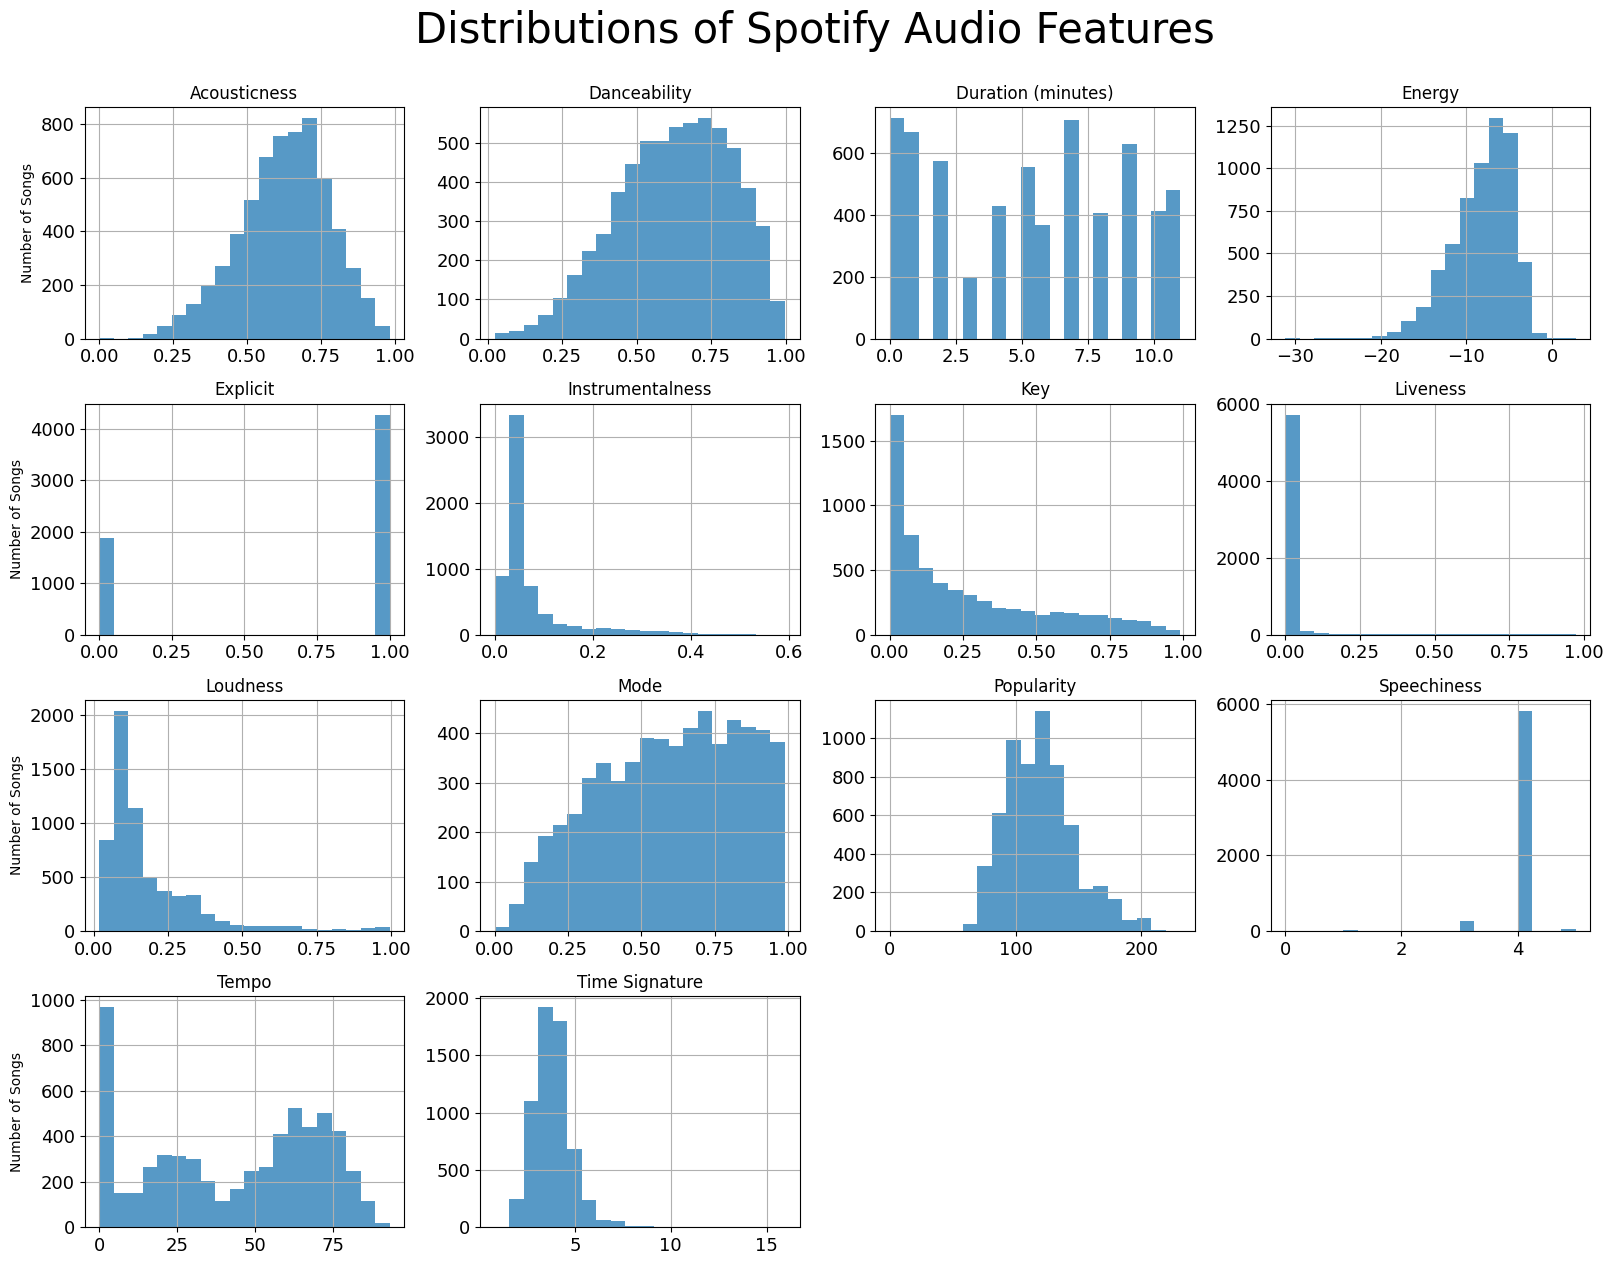

In [ ]:
axes = df.drop(['year', 'rank', 'num_words', 'uniq_ratio', 'decade',
                'num_uniq_words', 'words_per_sec'], axis=1)\
         .hist(figsize=(16,12), bins=20, alpha=0.75);
axes = axes.ravel()
plt.tight_layout()

titles = ['Acousticness', 'Danceability', 'Duration (minutes)', 'Energy',
          'Explicit', 'Instrumentalness', 'Key', 'Liveness', 'Loudness', 'Mode',
          'Popularity', 'Speechiness', 'Tempo', 'Time Signature', 'Valence']
for i in range(len(axes)-1):
    axes[i].set_title(titles[i])
    if i % 4 == 0:
        axes[i].set_ylabel('Number of Songs')
plt.suptitle('Distributions of Spotify Audio Features', fontsize=30, y=1.05);

## Most popular Artitst

<ipython-input-48-723590558a9c>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('inferno')


Text(32.5, 1, 'Billboard Year-End\nHot 100 1960-2022')

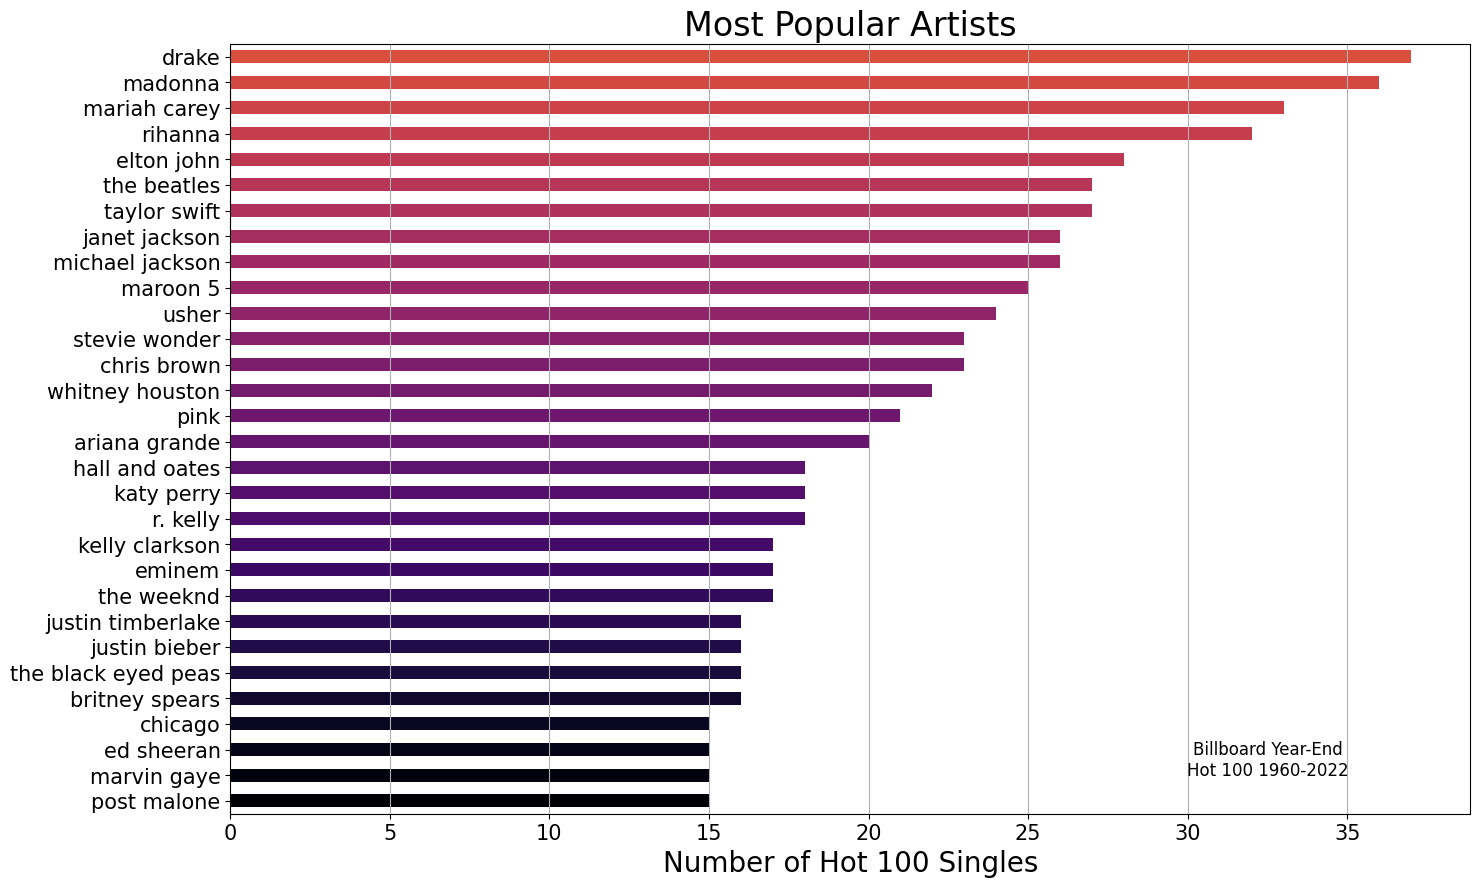

In [ ]:
cmap = plt.cm.get_cmap('inferno')
colors = [cmap(x) for x in np.linspace(0, 1, 50)]

ax = df['artist_base'].value_counts().sort_values().tail(30)\
                       .plot.barh(figsize=(16,10), color=colors, fontsize=15)
ax.xaxis.grid(True)
ax.set_xlabel('Number of Hot 100 Singles', fontsize=20)
ax.set_title('Most Popular Artists', fontsize=24)
ax.annotate('Billboard Year-End\nHot 100 1960-2022', xy=(32.5,1),
            fontsize=12, ha='center')

In [8]:
# artist longevity is difference between year of newest hit and oldest hit + 1
longevity = df.groupby('artist_base').agg({'year': np.ptp})
longevity.columns = ['longevity']

# keep only 30 artists with longest career spans
longevity = longevity.sort_values(by='longevity', ascending=False).head(30)

# get years for newest and oldest hit
min_max_years = df.groupby('artist_base')['year'].agg([min, max])

# filter billboard song data for only long-career-span artists
timeless = lambda x: True if x in longevity.index else False
timeless_df = df[['artist_base', 'year']][df['artist_base'].apply(timeless)]

<ipython-input-12-a9394c1c83e4>:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=timeless_df, x='year', y='artist_base', jitter=True,


Text(2013, 28, 'Billboard Year-End\nHot 100 1960-2022')

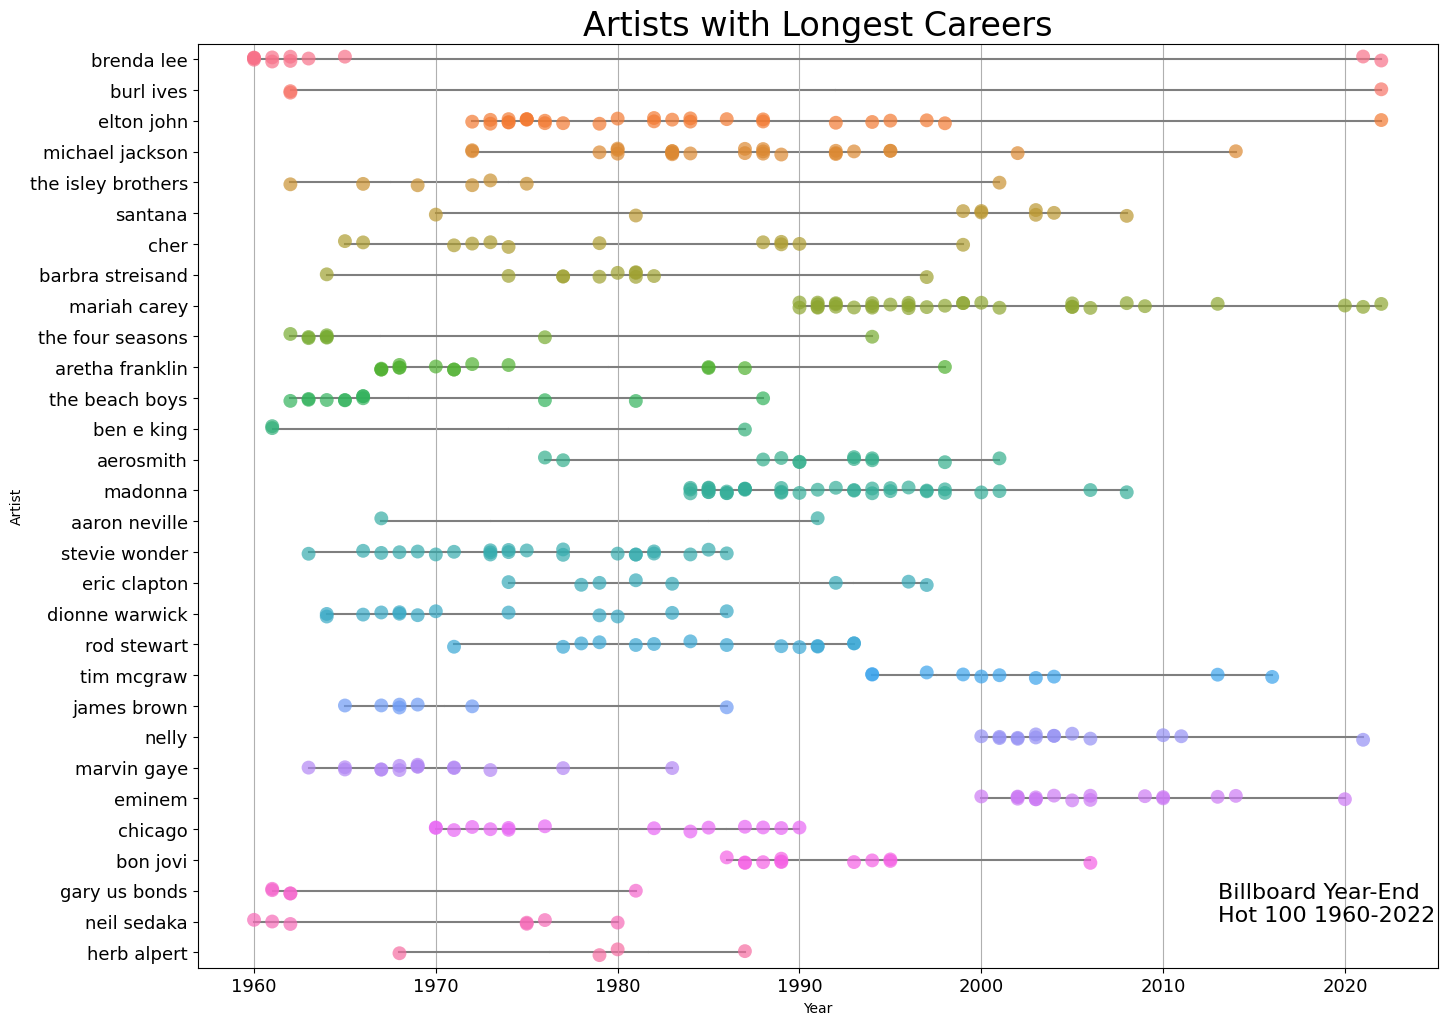

In [12]:
# plot timelines of hits for each artist, ordered by career spans
plt.figure(figsize=(16,12))
ax = sns.stripplot(data=timeless_df, x='year', y='artist_base', jitter=True, 
              order=longevity.index, size=10, alpha=0.7, palette= sns.color_palette("husl", 30))
sns.boxplot(data=timeless_df, x='year', y='artist_base', ax=ax, width=0, whis= 20,
            order=longevity.index, color='lightgray')
ax.xaxis.grid(True)
ax.set(ylabel='Artist', xlabel='Year')
ax.set_title('Artists with Longest Careers', fontsize=24)
ax.annotate('Billboard Year-End\nHot 100 1960-2022',
            xy=(2013,28), fontsize=16)

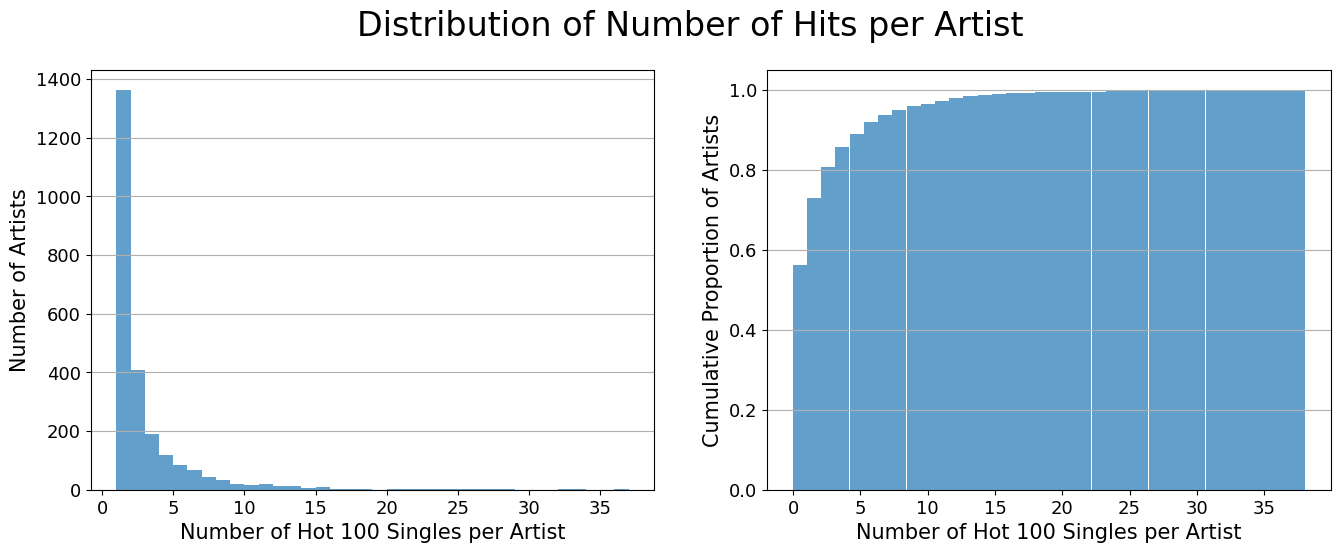

In [ ]:
# generate subplots
axes = list()
plt.figure(figsize=(16,12))
grid_positions = [221, 222]
for position in grid_positions:
    axes.append(plt.subplot(position))

# generate upper left histogram
df['artist_base'].value_counts().plot.hist(bins=36, ax=axes[0], alpha=0.7)
axes[0].set_ylabel('Number of Artists', fontsize=15)

# generate upper right cumulative relative frequency histogram
counts = df['artist_base'].value_counts()
res = relfreq(counts, numbins=36)
x = res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size,
                                 res.frequency.size)
axes[1].bar(x, np.cumsum(res.frequency), width=res.binsize+0.02, alpha=0.7)
axes[1].set_ylabel('Cumulative Proportion of Artists', fontsize=15)

for ax in axes[:2]:
    ax.set_xlabel('Number of Hot 100 Singles per Artist', fontsize=15)
    ax.yaxis.grid(True)

plt.suptitle('Distribution of Number of Hits per Artist',
             fontsize=24, y=0.93);

In [ ]:
(df['artist_base'].value_counts() <= 3).sum() / (len(df['artist_base'].value_counts()))

0.8074074074074075

# Artist diversity over time

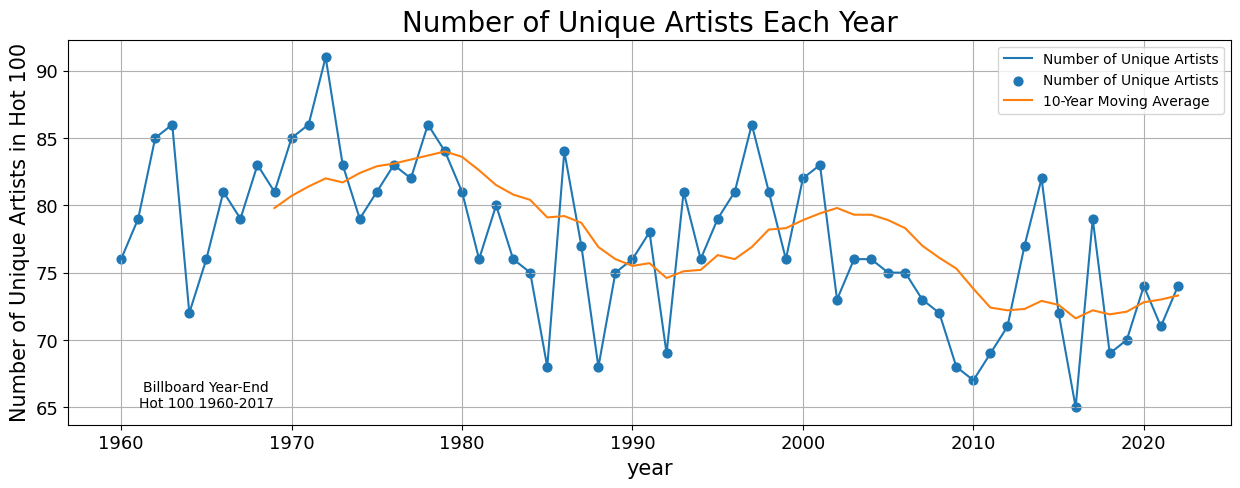

In [ ]:
# calculate number of unique artists for each year
nunique_artists_year = df.groupby(['year'])['artist_base'].agg(pd.Series.nunique)

# generate line plot and augment with points
ax = nunique_artists_year.plot.line(figsize = (15,5), grid=True, label='# unique artists')
ax.scatter(nunique_artists_year.index, nunique_artists_year, s=40)
ax.set_ylabel('Number of Unique Artists in Hot 100', fontsize=15)
ax.set_xlabel("Year", fontsize=15)
ax.set_title('Number of Unique Artists Each Year', fontsize=20)

# denoise with a 10-year moving average
nunique_artists_year.rolling(window=10).mean().plot(
    grid=True, label='10-year moving average')
ax.annotate('Billboard Year-End\nHot 100 1960-2017', xy=(1965,65),
            fontsize=10, ha='center')
plt.legend(['Number of Unique Artists', "Number of Unique Artists",  '10-Year Moving Average']);

# Artist collaboration over time

Text(1962, 1.5, 'Billboard Year-End\nHot 100 1960-2022')

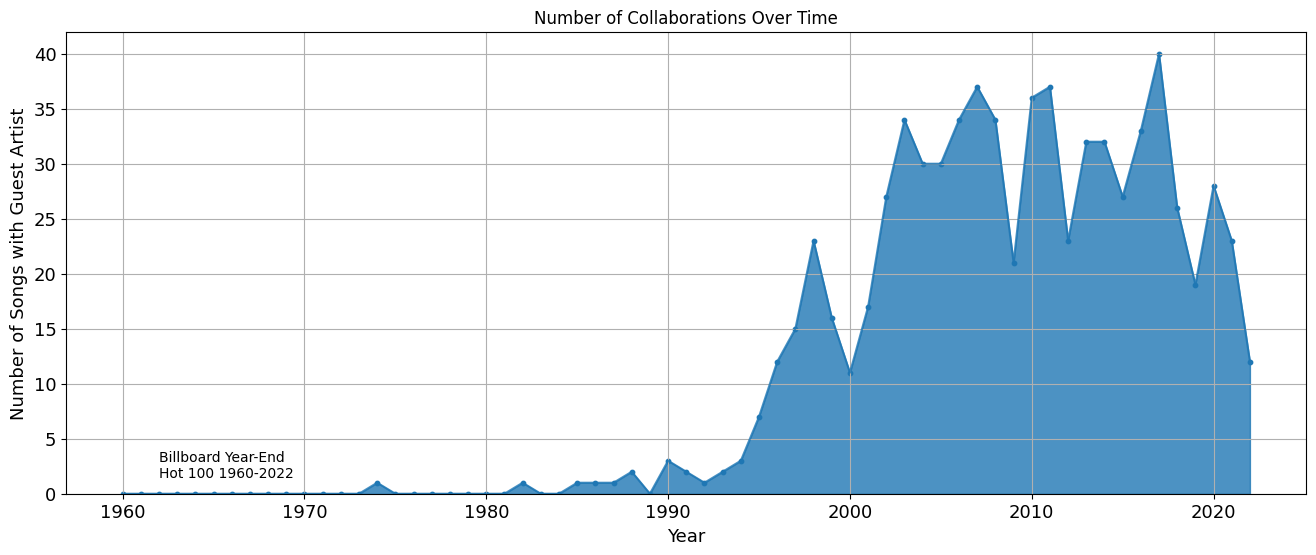

In [ ]:
# collaboration counted if artist name contains "featuring"
df_collab = df[df['artist_all'].str.contains('featuring')]
df_collab = df_collab.groupby(['year'])['artist_base']\
                     .count().reindex(range(1960, 2023))
df_collab = df_collab.fillna(0)

# generate line plot and augment with points
ax = df_collab.plot.area(figsize=(16,6), grid=True, alpha=0.8)
ax.scatter(df_collab.index, df_collab, s=10)
ax.set_ylabel('Number of Songs with Guest Artist',fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set(title='Number of Collaborations Over Time')
ax.annotate('Billboard Year-End\nHot 100 1960-2022',
            xy=(1962,1.5))

<ipython-input-16-825ce281cb65>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


Text(0.5, 1.04, 'Number of Collaborations per Artist')

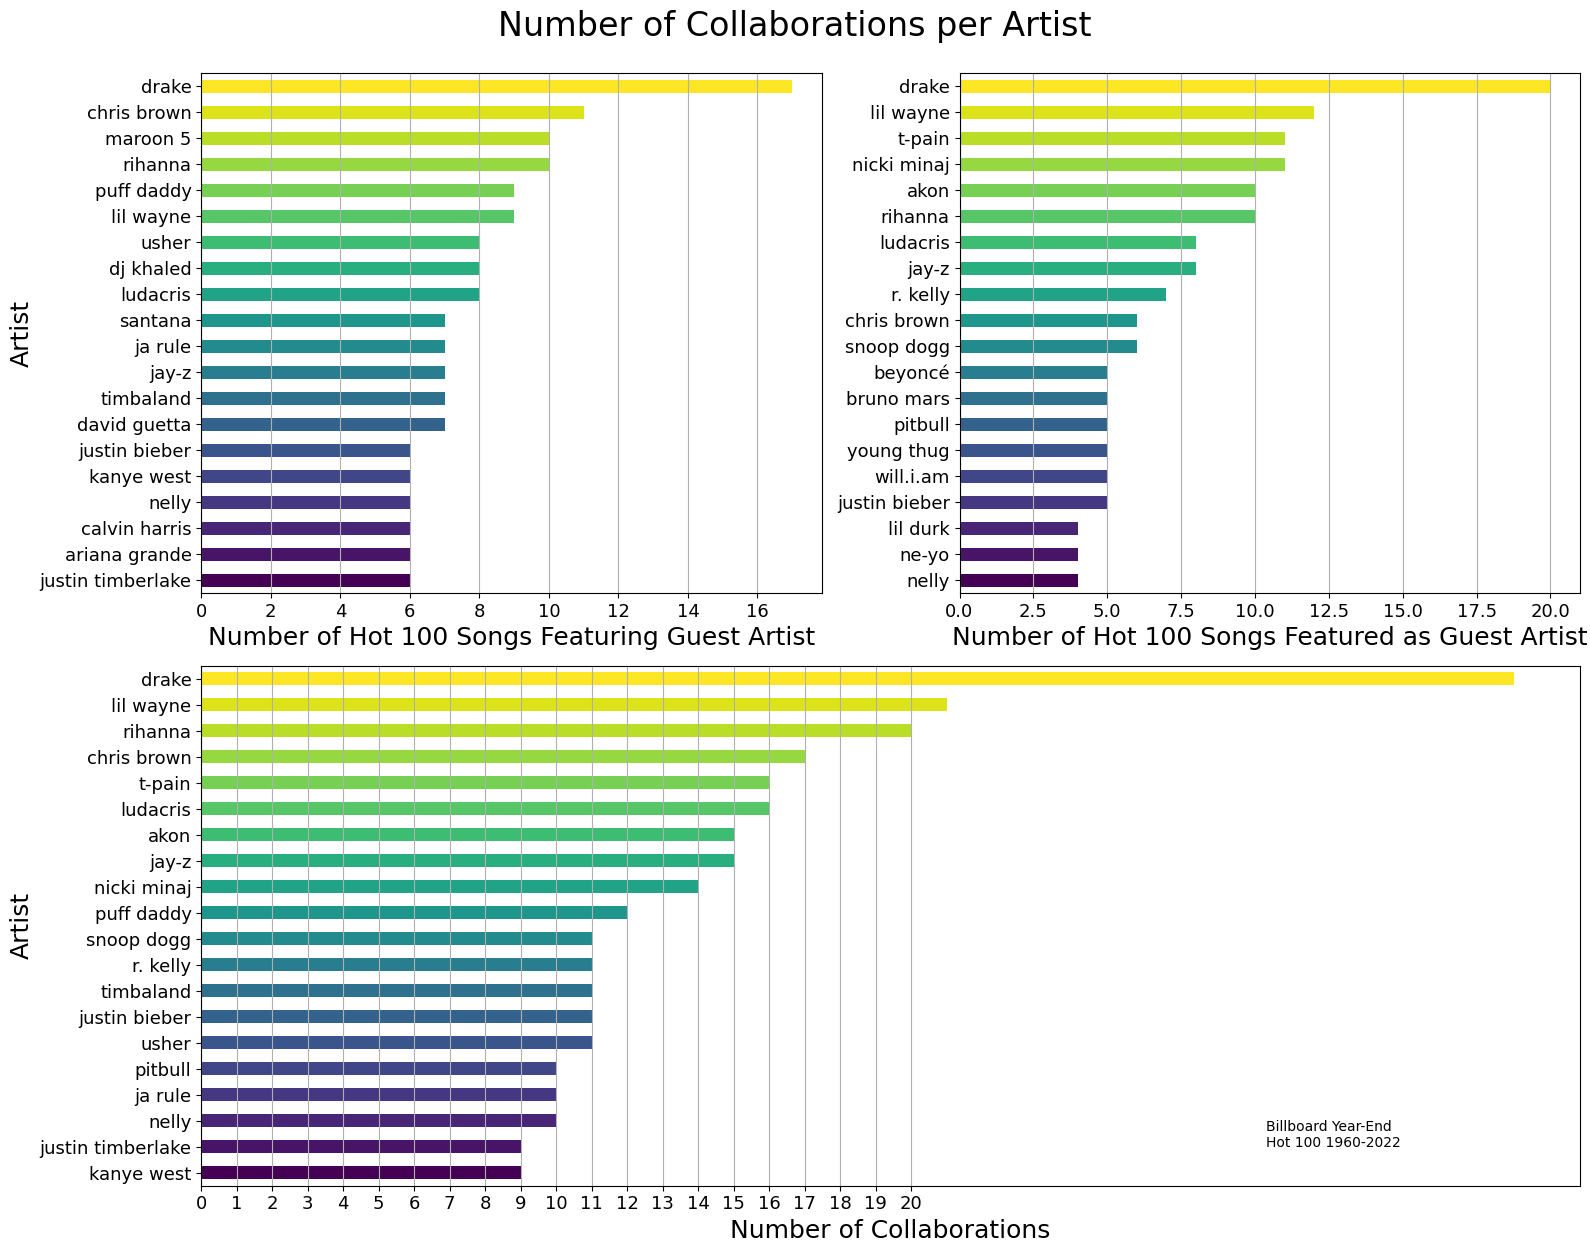

In [ ]:
cmap = plt.cm.get_cmap('viridis')
colors = [cmap(x) for x in np.linspace(0, 1, 20)]

# generate subplots
axes = list()
plt.figure(figsize=(16,12))
grid_positions = [221, 222, 212]
for position in grid_positions:
    axes.append(plt.subplot(position))

# calculate "featuring" vs "featured" stats for each artist
featuring = df.groupby('artist_base')['artist_featured'].count()
featured = df['artist_featured'].value_counts()

# generate upper two plots
featuring.sort_values().tail(20).plot.barh(ax=axes[0], color=colors)
featured.sort_values().tail(20).plot.barh(ax=axes[1], color=colors)
axes[0].set_xlabel('Number of Hot 100 Songs Featuring Guest Artist', fontsize=18)
axes[0].set_ylabel('Artist', fontsize=18)

axes[1].set_xlabel('Number of Hot 100 Songs Featured as Guest Artist', fontsize=18)

# indices must be reset for merging by artist
featuring = featuring.reset_index()
featured = featured.reset_index()
merged = pd.merge(featuring, featured, how='inner', left_on='artist_base',
                  right_on='index')
merged = merged.drop('index', axis=1)

# calculate number of collborations from "featuring" and "featured" stats
merged.columns = ['artist', 'n_featuring', 'n_featured']
merged['n_collab'] = merged['n_featuring'] + merged['n_featured']
merged = merged.set_index('artist') # for yticklabels when plotting

# generate lower plot
axes[2] = merged['n_collab'].sort_values().tail(20).plot.barh(color=colors)
axes[2].set_xlabel('Number of Collaborations', fontsize=18)
axes[2].set_ylabel('Artist', fontsize=18)
axes[2].set_xticks(range(0,21,1));
axes[2].annotate('Billboard Year-End\nHot 100 1960-2022',
    xy=(30,1))

# final touches
for ax in axes:
    ax.xaxis.grid(True)
plt.tight_layout()
plt.suptitle('Number of Collaborations per Artist', fontsize=24, y=1.04)

# Collaboration connection

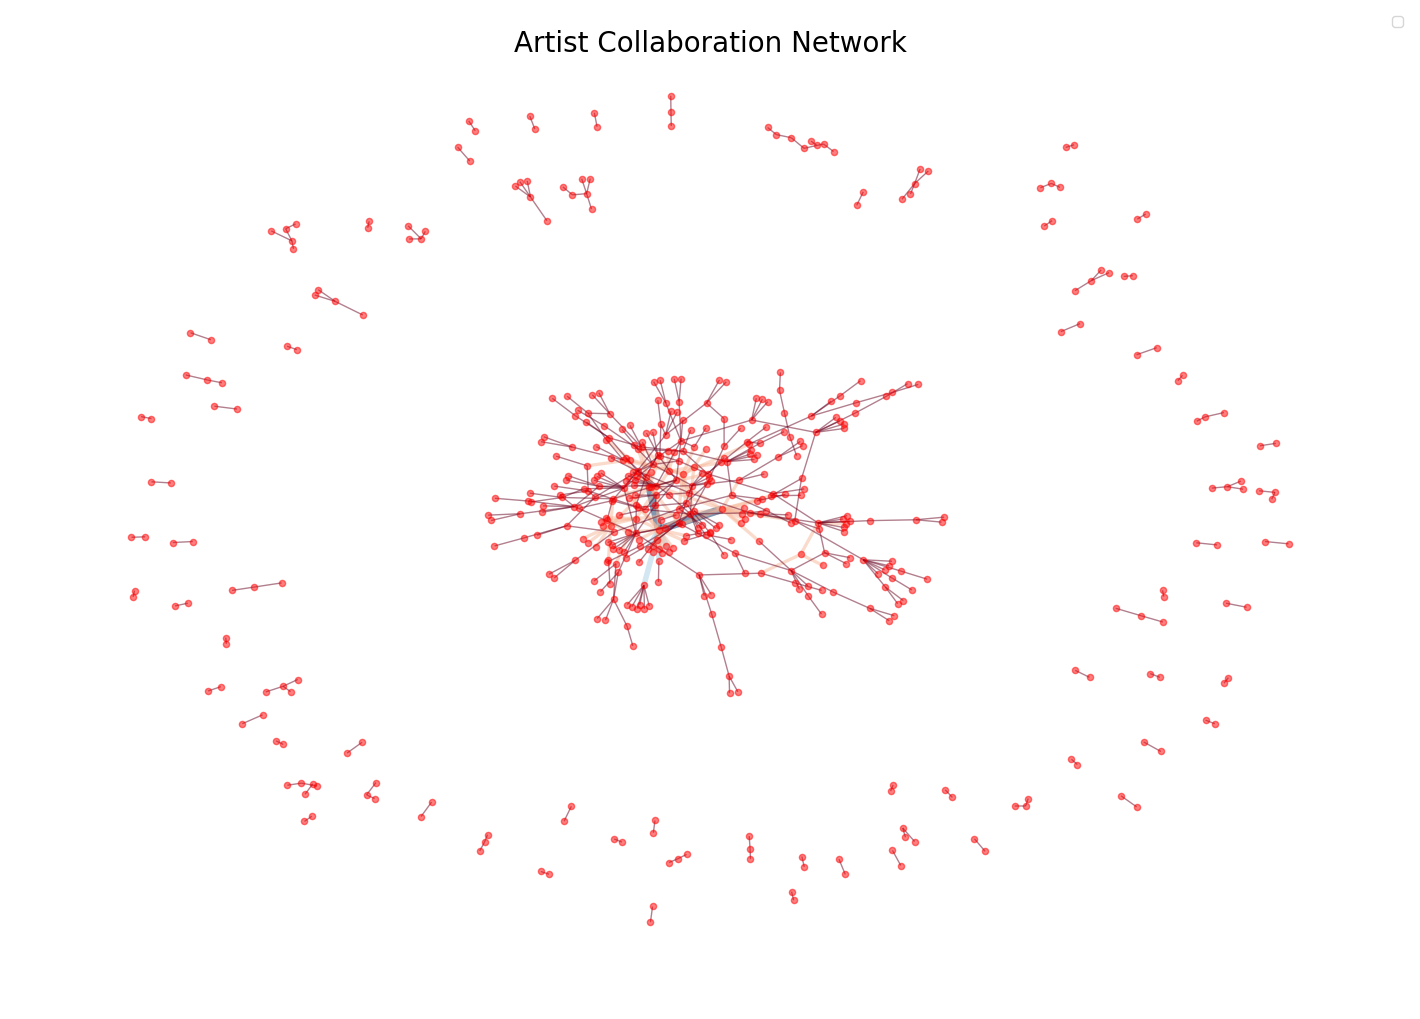

In [17]:
# exclude single-hit artist to simply network visualization
vc = df.artist_base.value_counts()
exclude = vc[vc == 1].index

# visualize collaborations as undirected edges weighted by frequency
edges = df[df.artist_featured.notnull()][['artist_base', 'artist_featured']]
u_edges = list()
for index, row in edges.iterrows():
    artist1 = row['artist_base'].strip()
    artist2 = row['artist_featured'].strip()
    if artist1 in exclude or artist2 in exclude:
        continue
    # to use groupby to obtain weights, must first normalize all artist pairs
    # normalize artist pair by rearranging alphabetically
    new_row = sorted([artist1, artist2])
    u_edges.append(new_row)

# use dummy column of ones and multi-column groupby to obtain edge frequencies
u_edges_df = pd.DataFrame(u_edges)
u_edges_df['one'] = 1
u_edges_df = u_edges_df.groupby([0, 1])['one']\
                       .count().sort_values(ascending=False).reset_index()
u_edges_df.columns = ['artist1', 'artist2', 'degree']

# generate graph. edge width and color is function of frequency (degrees)
degrees = u_edges_df['degree']
u_edges = u_edges_df[['artist1', 'artist2']]
u_edges = u_edges.values.tolist()
graph = nx.Graph(directed=True)
graph.add_edges_from(u_edges)
plt.figure(figsize=(14,10))
nx.draw_spring(graph, node_size=20, edge_color=degrees, edge_cmap=plt.cm.RdBu,
               width=degrees**1.25, alpha=0.5, font_size=5, node_color='r')
plt.suptitle('Artist Collaboration Network', fontsize=20)
plt.legend()

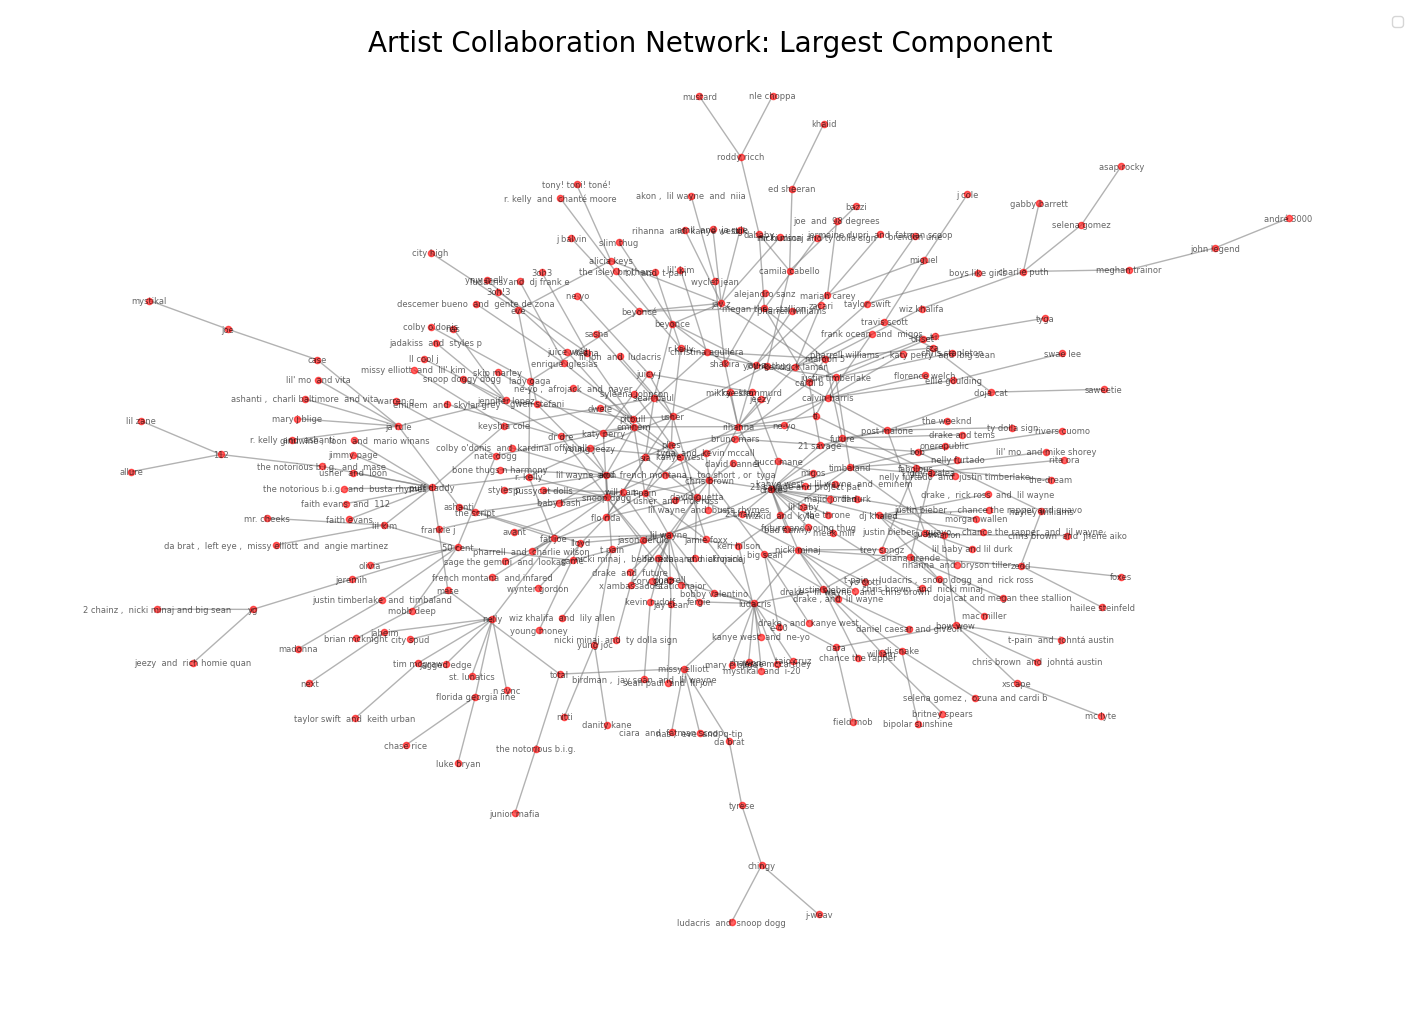

In [18]:
# plot largest component of graph
component = max((graph.subgraph(c) for c in nx.connected_components(graph)), key=len)
plt.figure(figsize=(14,10))
nx.draw_kamada_kawai(component, node_size=20, with_labels=True, font_size=6,
                     alpha=0.6, edge_color='gray', node_color='r')
plt.suptitle('Artist Collaboration Network: Largest Component', fontsize=20)
plt.legend()